In [1]:
import pandas as pd
df = pd.read_csv("/home/yair/Documents/Bar-Ilan/third-year/semester2/Statistical-Theory/heart_disease_dataset.csv")
df.head()

,Age,Gender,Cholesterol,Blood Pressure,Heart Rate,Smoking,Alcohol Intake,Exercise Hours,Family History,Diabetes,Obesity,Stress Level,Blood Sugar,Exercise Induced Angina,Chest Pain Type,Heart Disease
0,75,Female,228,119,66,Current,Heavy,1,No,No,Yes,8,119,Yes,Atypical Angina,1
1,48,Male,204,165,62,Current,Nothing,5,No,No,No,9,70,Yes,Typical Angina,0
2,53,Male,234,91,67,Never,Heavy,3,Yes,No,Yes,5,196,Yes,Atypical Angina,1
3,69,Female,192,90,72,Current,Nothing,4,No,Yes,No,7,107,Yes,Non-anginal Pain,0
4,62,Female,172,163,93,Never,Nothing,6,No,Yes,No,2,183,Yes,Asymptomatic,0


## Correlation matrix for the numerical features

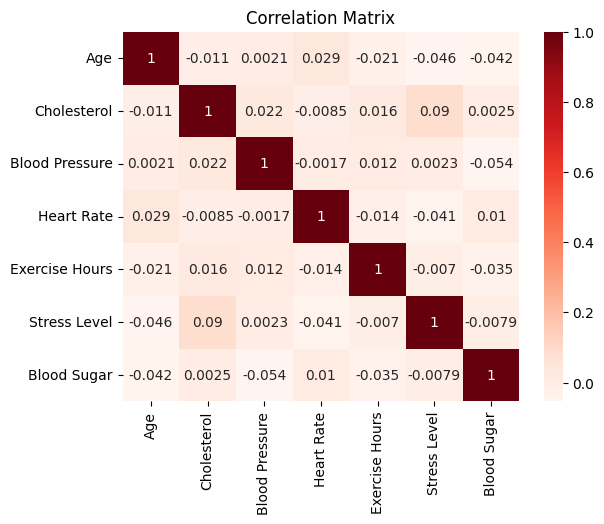

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numerical_features].drop("Heart Disease",axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="Reds")
plt.title('Correlation Matrix')
plt.show()

## Now Let's check the significance of this result:

In [3]:
from scipy import stats

# Create a function to calculate p-values
def calculate_p_values(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvals = dfcols.transpose().join(dfcols, how='outer')

    for r in df.columns:
        for c in df.columns:
            if r == c:
                pvals[r][c] = None  # NaN for self-correlation
            else:
                pvals[r][c] = round(stats.pearsonr(df[r], df[c])[1], 4)
    return pvals

p_values_matrix = calculate_p_values(df[numerical_features].drop("Heart Disease",axis=1))


/tmp/ipykernel_7889/477487292.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvals[r][c] = None  # NaN for self-correlation
/tmp/ipykernel_7889/477487292.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0

# correlation between numerical and categorail features

In [4]:
from sklearn.preprocessing import OneHotEncoder

numerical_columns = df.select_dtypes(include=[np.number]).drop(columns='Heart Disease').columns
categorical_columns = df.select_dtypes(include=[object]).columns

# One-Hot Encode the categorical variables
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(df[categorical_columns])
one_hot_encoded_df = pd.DataFrame(one_hot_encoded.toarray(), columns=one_hot_encoder.get_feature_names_out(categorical_columns))


In [5]:
from scipy.stats import pointbiserialr

# Combine the one-hot encoded columns back with the numerical columns
df_encoded = pd.concat([df[numerical_columns], one_hot_encoded_df], axis=1)

# Calculate the Point Biserial Correlation for each one-hot encoded variable
cat_num_correlation_matrix = pd.DataFrame(index=one_hot_encoded_df.columns, columns=numerical_columns)

for cat_col in one_hot_encoded_df.columns:
    for num_col in numerical_columns:
        correlation, _ = pointbiserialr(one_hot_encoded_df[cat_col], df[num_col])
        cat_num_correlation_matrix.loc[cat_col, num_col] = correlation

# Display the results
print("Categorical-Numerical Correlation Matrix (Point Biserial):")
print(cat_num_correlation_matrix)


Categorical-Numerical Correlation Matrix (Point Biserial):
                                       Age Cholesterol Blood Pressure  \
Gender_Female                    -0.014044    0.012566       0.023785   
Gender_Male                       0.014044   -0.012566      -0.023785   
Smoking_Current                   0.035631    0.015343       0.020997   
Smoking_Former                   -0.058564    -0.05805      -0.012505   
Smoking_Never                     0.022455    0.042204      -0.008575   
Alcohol Intake_Heavy             -0.058626   -0.034678       0.015684   
Alcohol Intake_Moderate           0.072372    0.041173      -0.001081   
Alcohol Intake_Nothing           -0.012035   -0.005516       -0.01469   
Family History_No                -0.017532    0.007862        0.01541   
Family History_Yes                0.017532   -0.007862       -0.01541   
Diabetes_No                       0.011193    0.028409       0.065437   
Diabetes_Yes                     -0.011193   -0.028409      -0.06

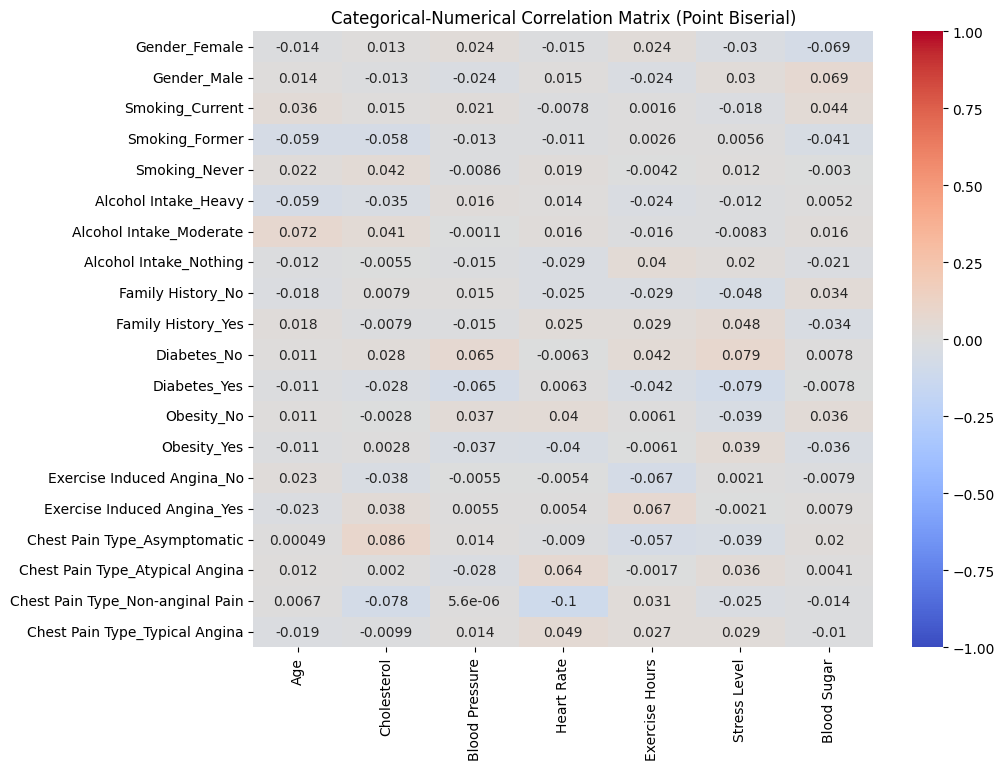

In [6]:
cat_num_correlation_matrix = cat_num_correlation_matrix.astype(float)

# Plot the heatmap for Point Biserial Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cat_num_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Categorical-Numerical Correlation Matrix (Point Biserial)')
plt.show()

# Now for correlation between categorial and other categorail :

In [7]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """ Calculate Cramér's V statistic for categorical-categorical association. """
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))


cat_cat_correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Compute Cramér's V for each pair of categorical variables
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cat_cat_correlation_matrix.loc[col1, col2] = 1.0  # correlation with itself is 1
        else:
            cat_cat_correlation_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Display the results
print("Categorical-Categorical Correlation Matrix (Cramér's V):")
print(cat_cat_correlation_matrix)

Categorical-Categorical Correlation Matrix (Cramér's V):
                           Gender   Smoking Alcohol Intake Family History  \
Gender                        1.0   0.03049        0.07246        0.09799   
Smoking                   0.03049       1.0       0.013822       0.032686   
Alcohol Intake            0.07246  0.013822            1.0       0.029708   
Family History            0.09799  0.032686       0.029708            1.0   
Diabetes                 0.037943  0.035865       0.022379       0.018021   
Obesity                  0.054013  0.034482       0.088052       0.009996   
Exercise Induced Angina   0.00367  0.019163       0.048733            0.0   
Chest Pain Type          0.022963  0.032512       0.050835       0.063204   

                         Diabetes   Obesity Exercise Induced Angina  \
Gender                   0.037943  0.054013                 0.00367   
Smoking                  0.035865  0.034482                0.019163   
Alcohol Intake           0.022379  0

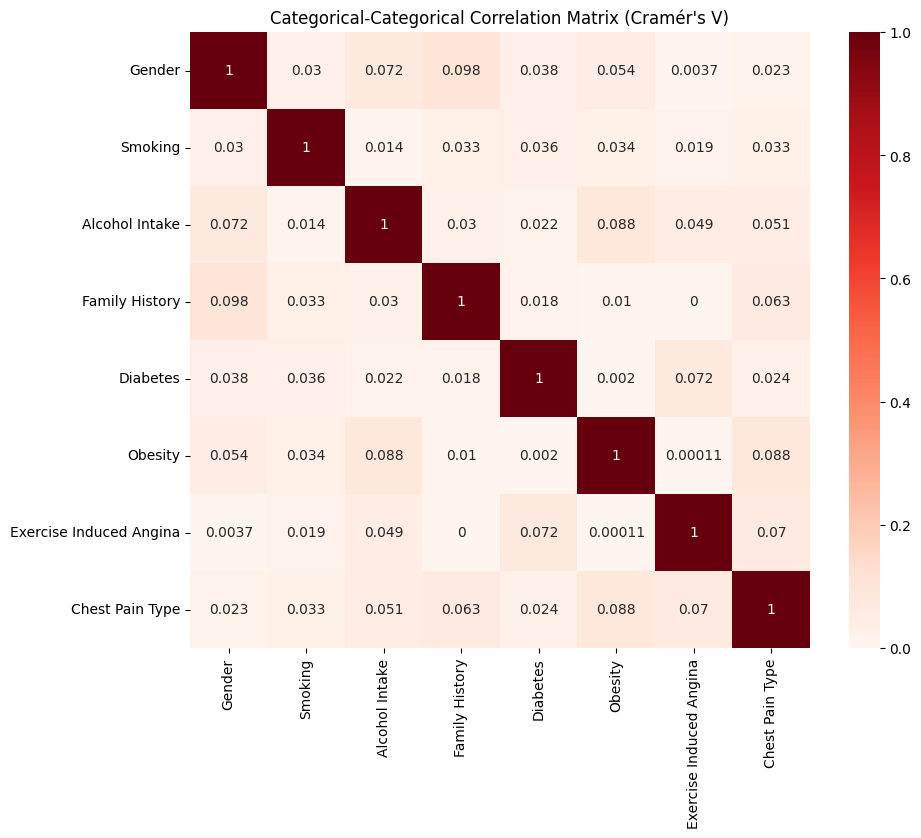

In [8]:
cat_cat_correlation_matrix = cat_cat_correlation_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cat_cat_correlation_matrix, annot=True, cmap='Reds', vmin=0, vmax=1)
plt.title('Categorical-Categorical Correlation Matrix (Cramér\'s V)')
plt.show()

### For conclusion, it doesn't seems like there is a big correlation between any of the features. that is a good thing, because it should help our machine learning model in his prediction.